In [1]:
##########################################################
# DSC5103 Statistics
# Session 2. Demo of k-nearest neighbour classification on the mixture.example dataset
# 2016.11
#
# -- based on the mixture.example dataset and documentation in the "ElemStatLearn" package
# -- more data details can be found at http://statweb.stanford.edu/~tibs/ElemStatLearn/datasets/mixture.example.info.txt
##########################################################

In [2]:
import rpy2.robjects as robjects
import numpy as np
import pandas
import seaborn as sns

In [3]:
#############################
### Loading data
#############################
# the dataset "mixture.example" is from R package "ElemStatLearn"
## data below is saved as mixture_example.RData
# x <- mixture.example$x
# y <- mixture.example$y
# prob <- mixture.example$prob
# xnew <- mixture.example$xnew
# px1 <- mixture.example$px1
# px2 <- mixture.example$px2

In [4]:
robjects.r['load']("mixture_example.RData")

R object with classes: ('character',) mapped to:
<StrVector - Python:0x11990fbc8 / R:0x107cff418>
['.Ran..., 'px1', 'px2', ..., 'x', 'y', 'xnew']

In [5]:
whos

Variable   Type      Data/Info
------------------------------
np         module    <module 'numpy' from '/Us<...>kages/numpy/__init__.py'>
pandas     module    <module 'pandas' from '/U<...>ages/pandas/__init__.py'>
robjects   module    <module 'rpy2.robjects' f<...>y2/robjects/__init__.py'>
sns        module    <module 'seaborn' from '/<...>ges/seaborn/__init__.py'>


In [6]:
# trasform r data into numpy data
x = robjects.r['x']
xnew = robjects.r['xnew']
prob = robjects.r['prob']
px1 = robjects.r['px1']
px2 = robjects.r['px2']
y = robjects.r['y']
x = np.array(x)
xnew = np.matrix(xnew)
prob = np.array(prob)
px1 = np.array(px1)
px2 = np.array(px2)
y = np.array(y)
prob = prob.reshape(6831,1)

In [7]:
print(x.shape, xnew.shape, prob.shape, px1.shape, px2.shape, y.shape)

(200, 2) (6831, 2) (6831, 1) (69,) (99,) (200,)


In [8]:
# give y categorical labels
y = pandas.Categorical(y)

In [9]:
# make dataframe for x and y (for ggplot use)
df_training = pandas.DataFrame({'x1':x[:,0], 'x2':x[:,1], 'y':y})
df_training.describe()

,x1,x2
count,200.000000,200.000000
mean,0.784672,0.756016
std,1.297582,1.026442
min,-2.520820,-1.999853
25%,-0.071465,0.095555
50%,0.859702,0.861387
75%,1.543438,1.435275
max,4.170746,2.855805


In [10]:
# for plotting the boundary
x1, x2 = np.meshgrid(px1, px2)              # create the "base grid"
prob1 = prob.reshape(99,69)

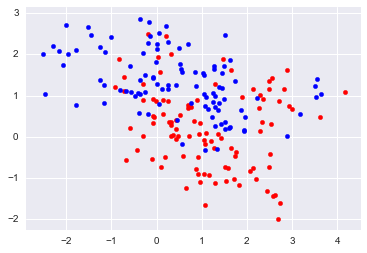

In [11]:
# plot X and Y with matplotlib
import matplotlib.pyplot as plt
#show the plot in current web page
%matplotlib inline
plt.scatter(x[y == 0, 0], x[y == 0, 1], color='r')
plt.scatter(x[y == 1, 0], x[y == 1, 1], color='b')
plt.axis('tight')
plt.show()

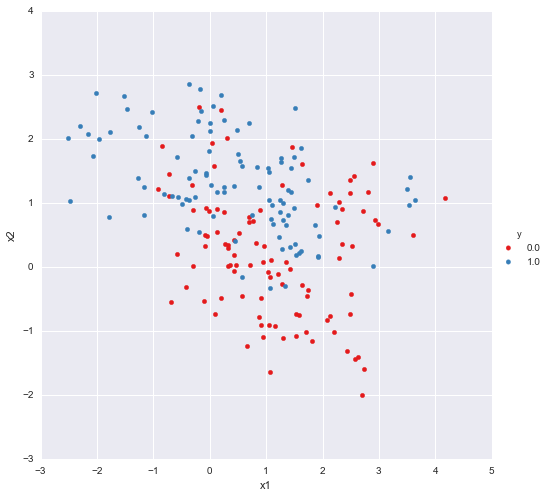

In [12]:
# plot X and Y with seaborn
# http://seaborn.pydata.org/generated/seaborn.FacetGrid.html
g = sns.FacetGrid(df_training, hue='y', palette="Set1", size = 7)
g.map(plt.scatter, 'x1', 'x2').add_legend()

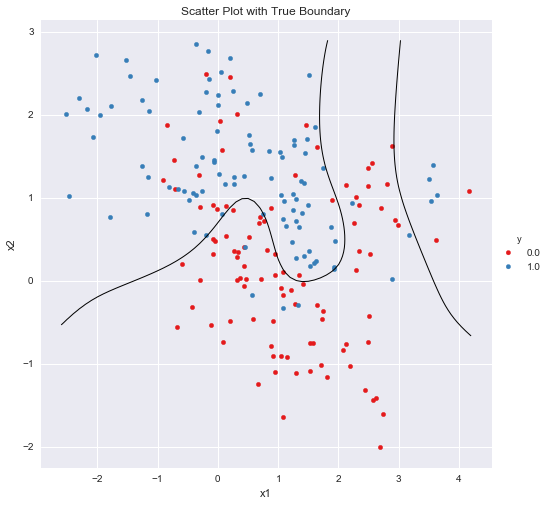

In [13]:
# add the true boundary into the plot
# https://www.getdatajoy.com/examples/python-plots/contour-plots
levels = np.arange(0.5, 0.9, 0.5)
g = sns.FacetGrid(df_training, hue='y', palette="Set1", size = 7)
g.map(plt.scatter, 'x1', 'x2').add_legend()
plt.contour(x1, x2, prob1, levels, 
                 colors='black',                # lines colour 
                 linewidths=1)
g.ax.set_title('Scatter Plot with True Boundary')

In [14]:
#############################
### KNN classification
#############################

In [15]:
# knn classification is in package "sklearn" 
from sklearn import neighbors
# ?neighbors.KNeighborsClassifier

In [16]:
## 1. k=15, training MSE
knn15 = neighbors.KNeighborsClassifier(15, weights='uniform')
knn15fit = knn15.fit(x, y)

In [17]:
prob15 = knn15fit.predict_proba(xnew)[:,0]

In [18]:
prob15_1 = prob15.reshape(x1.shape)

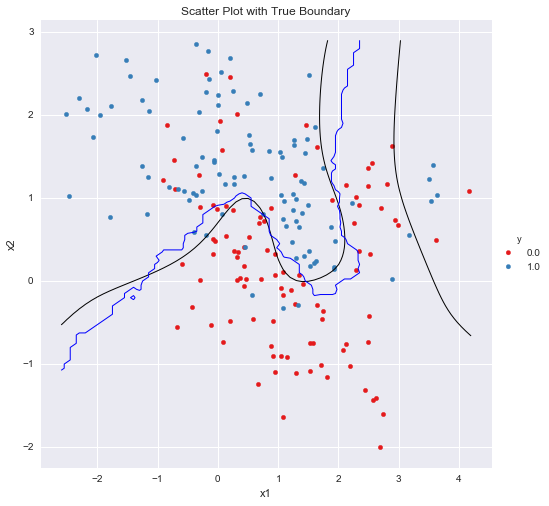

In [19]:
# plot
g = sns.FacetGrid(df_training, hue='y', palette="Set1", size = 7)
g.map(plt.scatter, 'x1', 'x2').add_legend()
plt.contour(x1, x2, prob1, levels, 
                 colors='black',                # lines colour 
                 linewidths=1)
plt.contour(x1, x2, prob15_1, levels, 
                 colors='blue',                # lines colour 
                 linewidths=1)
g.ax.set_title('Scatter Plot with True Boundary')

In [20]:
# Training Errors
y_hat15 = knn15fit.predict(x)
# total errors in training
y_hat15[y_hat15 != y].size
# misclassification rate in training
y_hat15[y_hat15 != y].size / y.size

0.155

In [21]:
## 2. Test Error
########################################################################
# generate test data:
# The data do not contain a test sample, so we make one,
# using the description of the oracle page 17 of the book: The centers 
# is in the means component of mixture.example, with green(0) first, 
# so red(1).  For a test sample of size 10000 we simulate
# 5000 observations of each class.

# the dataset was created by Prof Wang Tong and is saved as mixture_testdata.RData

In [22]:
robjects.r['load']("mixture_testdata.RData")

R object with classes: ('character',) mapped to:
<StrVector - Python:0x11cfff608 / R:0x107cff3b0>
['centers', '.Rando..., 'means', 'x.test', 'y.test']

In [23]:
# trasform r data into numpy data
xtest = robjects.r['x.test']
ytest = robjects.r['y.test']
xtest = np.array(xtest)
ytest = np.array(ytest)

In [25]:
# enumerate many many k values and measure misclassification rate
# k's that will be evaluated
ks = np.arange(1, 99.1, 2, dtype=np.int_)
# construct empty vectors for keeping the MSE for each k
misclass_train = np.zeros(ks.size,)
misclass_test = np.zeros(ks.size,)
for i in np.arange(1, ks.size + 0.1, 1, dtype=np.int_):
    knnen = neighbors.KNeighborsClassifier(ks[i-1], weights='uniform')
    model_train = knnen.fit(x, y).predict(x)
    model_test = knnen.fit(x, y).predict(xtest)
    misclass_train[i-1] = model_train[model_train != y].size / y.size
    misclass_test[i-1] = model_test[model_test != ytest].size / ytest.size

In [26]:
print(misclass_train)
print(misclass_test)

[ 0.     0.13   0.13   0.145  0.155  0.185  0.16   0.155  0.175  0.17
  0.175  0.175  0.17   0.17   0.17   0.18   0.18   0.2    0.21   0.225
  0.205  0.205  0.21   0.2    0.205  0.21   0.205  0.2    0.225  0.24   0.25
  0.24   0.245  0.26   0.25   0.26   0.265  0.27   0.265  0.26   0.265
  0.265  0.275  0.28   0.275  0.275  0.27   0.285  0.29   0.3  ]
[ 0.2935  0.2438  0.2266  0.225   0.2283  0.2472  0.2487  0.2479  0.2468
  0.2495  0.2493  0.2485  0.2503  0.2528  0.2547  0.2592  0.2621  0.2648
  0.2733  0.2792  0.2787  0.2741  0.2646  0.2672  0.2688  0.2722  0.2743
  0.278   0.2803  0.2865  0.2886  0.2873  0.2894  0.2896  0.2884  0.2836
  0.2821  0.2818  0.283   0.2836  0.2855  0.2902  0.2915  0.293   0.2947
  0.2926  0.2964  0.296   0.3014  0.3032]


In [27]:
# optimal k
k_opt = ks[np.argmin(misclass_test)]
print(k_opt)
# optimal misclassification rate
misclass_opt = np.min(misclass_test)
print(misclass_opt)

7
0.225


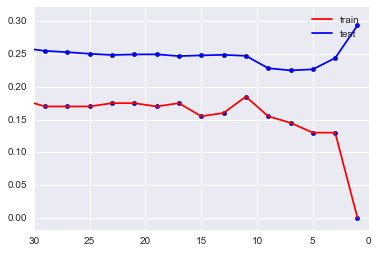

In [28]:
# plot misclassification rate on Training and Test
plt.plot(ks, misclass_train, c='r', label='train')
plt.scatter(ks, misclass_train)
plt.plot(ks, misclass_test, c='b', label='test')
plt.scatter(ks, misclass_test)
plt.axis('tight')
plt.legend()
plt.gca().set_xlim([0,30])
plt.gca().invert_xaxis()
plt.show()